In [3]:
# Load MARVEL package
library(MARVEL)

# Load adjunct packages for selected MARVEL features
  # General data processing, plotting
library(ggnewscale)
library(ggrepel)
library(reshape2)
library(plyr)
library(stringr)
library(textclean)

# Gene ontology analysis
library(AnnotationDbi)
library(clusterProfiler)
library(org.Hs.eg.db)
library(org.Mm.eg.db)

# ad hoc gene candidate gene analysis
library(gtools)

# Visualising splice junction location
library(GenomicRanges)
library(IRanges)
library(S4Vectors)
library(wiggleplotr)

# Load adjunct packages for this tutorial
library(Matrix)
library(data.table)
library(ggplot2)
library(gridExtra)

#
library(Seurat)
library(dplyr)

# Basic analysis

In [ ]:

gene.count.matrix.dir = paste0(celescope_outpath,'/L241207141/outs/filtered/')
sj.count.matrix.dir = '/L241207141/outs/SJ.raw'
gft.file = 'genome_gtf/Homo_sapiens.GRCh38.99.filter.gtf'

outpath = 'marvel_output'
if ( ! dir.exists(outpath)){dir.create (outpath)}
tsne_coord = read.table(paste0(celescope_outpath,'/L241207141/outs/tsne_coord.tsv'))

In [ ]:
sobj = CreateSeuratObject(Read10X(gene.count.matrix.dir),min.cells = 1,min.features = 1,)
sobj.norm <- NormalizeData(sobj, normalization.method = "RC",scale.factor = 10000) 
#gene expression norm
df.gene.norm <- sobj.norm@assays$RNA@data
df.gene.norm.pheno <- sobj.norm@meta.data
df.gene.norm.pheno["cell.id"] <- Cells(sobj.norm)
df.gene.norm.feature = data.frame(gene_short_name = rownames(sobj.norm))
#gene expression count
df.gene.count <- sobj.norm@assays$RNA@counts
df.gene.count.pheno <- sobj.norm@meta.data
df.gene.count.pheno["cell.id"] <- Cells(sobj.norm)
df.gene.count.feature = data.frame(gene_short_name = rownames(sobj.norm))
#Splice junction counts
sobj.sj = CreateSeuratObject(Read10X(sj.count.matrix.dir,gene.column = 1),min.cells = 1,min.features = 1)
sobj.sj = subset(sobj.sj,cells = Cells(sobj))
df.sj.count = sobj.sj@assays$RNA@counts
df.sj.count.pheno = data.frame(cell.id = colnames(df.sj.count))
df.sj.count.feature = data.frame(coord.intron = rownames(df.sj.count))

In [ ]:
# run cluster, if no tsne file supplied
nfeatures=2000
Dims =20
resolution=0.6
sobj.umap <- NormalizeData(sobj, normalization.method = "LogNormalize",scale.factor = 10000)
sobj.umap <- FindVariableFeatures(sobj.umap, selection.method = "vst", nfeatures = nfeatures, mean.cutoff = c(0.1, 8), 
                            dispersion.cutoff = c(1, Inf),
                            mean.function = ExpMean, dispersion.function = LogVMR)
use.genes <- sobj.umap@assays$RNA@var.features
sobj.umap <- ScaleData(sobj.umap, vars.to.regress = c("nCount_RNA","percent.mito"), features = use.genes) #no percent.mito

sobj.umap <- RunPCA(object = sobj.umap, features = use.genes, do.print = FALSE)

sobj.umap <- FindNeighbors(sobj.umap, dims = 1:Dims, force.recalc = TRUE, reduction = "pca")
sobj.umap <- FindClusters(sobj.umap, resolution = resolution)

sobj.umap <- RunTSNE(sobj.umap, dims = 1:Dims,check_duplicates = FALSE)

tsne_coord = as.data.frame(sobj.umap@reductions$tsne@cell.embeddings)

In [ ]:
df.coord = data.frame(cell.id = rownames(tsne_coord),
                      x = tsne_coord$tSNE_1,
                      y = tsne_coord$tSNE_2
                     )
rownames(df.coord) = df.coord$cell.id

In [ ]:
gtf <- as.data.frame(fread(gft.file), 
                     sep="\t", header=FALSE, stringsAsFactors=FALSE)
colnames(gtf) = c('V1','V2','V3','V4','V5','V6','V7','V8','V9')
gtf$V1 <-  str_replace_all(gtf$V1,'_','-')

In [ ]:
#Create MARVEL object
marvel <- CreateMarvelObject.10x(gene.norm.matrix=df.gene.norm,
                                 gene.norm.pheno=df.gene.norm.pheno,
                                 gene.norm.feature=df.gene.norm.feature,
                                 gene.count.matrix=df.gene.count,
                                 gene.count.pheno=df.gene.count.pheno,
                                 gene.count.feature=df.gene.count.feature,
                                 sj.count.matrix=df.sj.count,
                                 sj.count.pheno=df.sj.count.pheno,
                                 sj.count.feature=df.sj.count.feature,
                                 pca=df.coord,
                                 gtf=gtf
                                 )
#Annotate gene metadata
marvel <- AnnotateGenes.10x(MarvelObject=marvel)
#Annotate junction metadata
marvel <- AnnotateSJ.10x(MarvelObject=marvel)
#Validate junctions
marvel_flt <- ValidateSJ.10x(MarvelObject=marvel)
#Subset CDS genes
marvel_flt <- FilterGenes.10x(MarvelObject=marvel)
#Pre-flight check
marvel_flt <- CheckAlignment.10x(MarvelObject=marvel)

file <- "MARVEL.RData"
save(marvel_flt, file=paste(outpath,'/',file, sep=""))
write.table(as.data.frame(table(marvel$sj.metadata$sj.type)),paste0(outpath,'/sj.type.stat.txt'),sep = ',',quote = FALSE,row.names = FALSE)

# statistics

In [ ]:
marvel = marvel_flt
sj_read = read.table(paste0(celescope_output,'/L241207141/02.starsolo/L241207141_SJ.out.tab'))

print(paste0("Cell Number: ",as.character(nrow(marvel$sample.metadata))))
print(paste0("SJ Number: ",as.character(nrow(marvel$sj.metadata))))

colSums(marvel$sj.count.matrix>0)->cell_sj
print(paste0("Mean SJs per cell: ",as.character(mean(cell_sj))))
print(paste0("Median SJs per cell: ",as.character(median(cell_sj))))

colSums(marvel$sj.count.matrix)->umi_sj
print(paste0("Mean UMI per cell: ",as.character(mean(umi_sj))))
print(paste0("Median UMI per cell: ",as.character(median(umi_sj))))

sj_read%>%mutate(sj_name = paste0('chr',V1,':',V2,':',V3),sj_read = V7+V8)->sj_read_1
sj_read_1$sj_name = str_replace_all(sj_read_1$sj_name,'_','-')
sj_read_1%>%filter(sj_name %in% marvel$sj.metadata$coord.intron)->sj_read_flt

print(paste0("Mean reads per SJ: ",as.character(mean(sj_read_flt$sj_read))))
print(paste0("Median reads per SJ: ",as.character(median(sj_read_flt$sj_read))))

rowSums(marvel$sj.count.matrix>0)->df
cbind(sj_read_flt,data.frame(cellNum=df))->sj_read_flt
sj_read_flt%>%filter(cellNum>0)%>%mutate(mean_read_sj = sj_read/cellNum)->sj_read_flt
print(paste0("Mean reads per SJ per cell: ",as.character(mean(sj_read_flt$mean_read_sj))))
print(paste0("Median reads per SJ per cell: ",as.character(median(sj_read_flt$mean_read_sj))))

print(paste0("Mean SJ read per cell: ",as.character(mean(sj_read_flt$sj_read))))
print(paste0("Median SJ read per cell: ",as.character(median(sj_read_flt$sj_read))))


data.frame(cell_numeber = nrow(marvel$sample.metadata),
           sj_number = nrow(marvel$sj.metadata),
           mean_sj_per_cell = mean(cell_sj),
           median_sj_per_cell = median(cell_sj),
           mean_umi_per_cell = mean(umi_sj),
           median_umi_per_cell = median(umi_sj),
           mean_SJ_read_per_cell = mean(sj_read_flt$sj_read),
           median_SJ_read_per_cell = median(sj_read_flt$sj_read),
           mean_read_per_sj_per_cell = mean(sj_read_flt$mean_read_sj),
           median_read_per_sj_per_cell = median(sj_read_flt$mean_read_sj)
          )->stat_df

write.table(t(stat_df),paste0(outpath,'/stat.txt'),sep = "\t",quote = FALSE)

# downstream analysis

In [ ]:
library(pheatmap)
library(reshape2)

In [2]:
path <- "analysis/" #marvel output filepath
file <- "MARVEL.RData"
data = load(paste(path, file, sep="")) #marvel_flt

### plot clusters

In [7]:
cluster_info = read.table('L241207141/outs/tsne_coord.tsv')
cluster_info$cluster = paste0('Cluster',as.character(cluster_info$cluster))

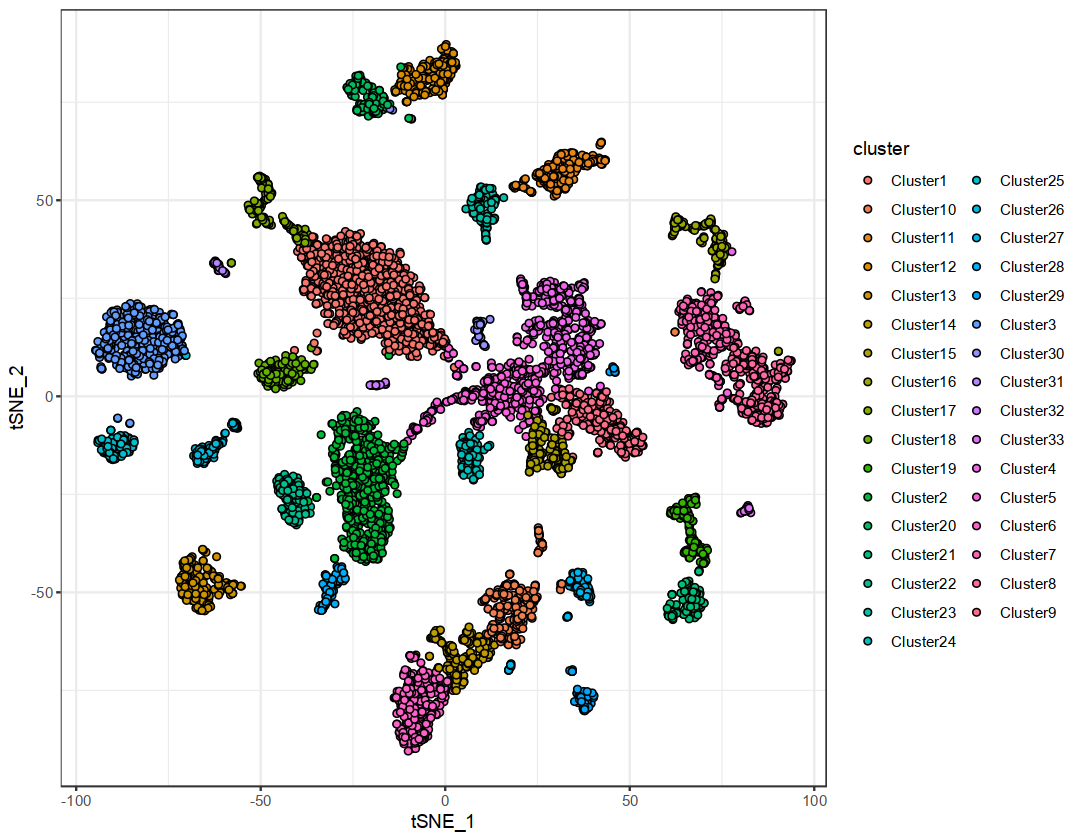

In [22]:
options(repr.plot.width=9)
ggplot(marvel_flt$sample.metadata,aes(x=tSNE_1,y=tSNE_2))+
geom_point(aes(fill=cluster),shape=21)+
theme_bw()

### gene/SJ expression in groups

In [115]:
sample.metadata <- marvel_flt$sample.metadata

# Group 1 (reference)
index <- which(sample.metadata$cluster=="Cluster1")
cell.ids.1 <- sample.metadata[index, "cell.id"]
length(cell.ids.1)

# Group 2 (reference)
index <- which(sample.metadata$cluster=="Cluster2")
cell.ids.2 <- sample.metadata[index, "cell.id"]
length(cell.ids.2)


[1] 785

[1] 552

In [24]:
marvel_flt <- PlotPctExprCells.Genes.10x(MarvelObject=marvel_flt,
                                     cell.group.g1=cell.ids.1,
                                     cell.group.g2=cell.ids.2,
                                     min.pct.cells=5
                                     )

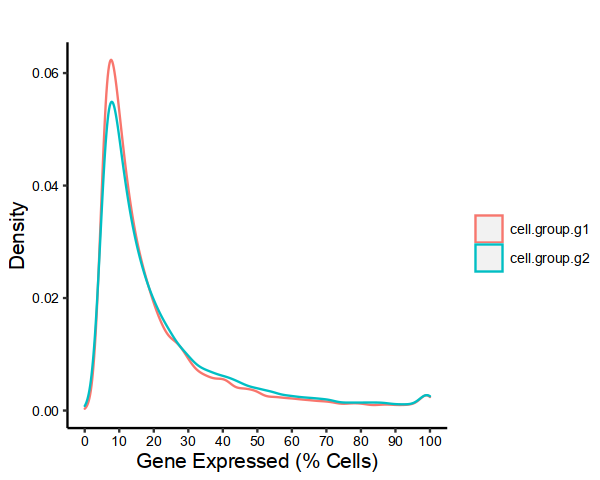

In [36]:
options(repr.plot.width=5,repr.plot.height=4)
marvel_flt$pct.cells.expr$Gene$Plot
ggsave('Demo/Gene_expression.png',marvel_flt$pct.cells.expr$Gene$Plot,width=4,height=3)

In [39]:
marvel_flt <- PlotPctExprCells.SJ.10x(MarvelObject=marvel_flt,
                                  cell.group.g1=cell.ids.1,
                                  cell.group.g2=cell.ids.2,
                                  min.pct.cells.genes=5,
                                  min.pct.cells.sj=5,
                                  downsample=TRUE,
                                  downsample.pct.sj=10
                                  )

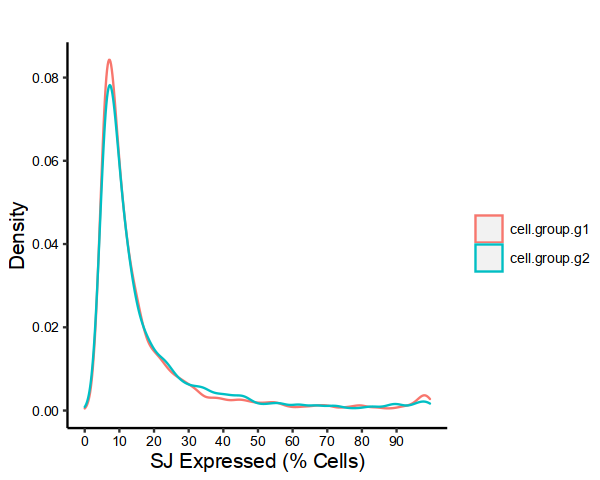

In [41]:
options(repr.plot.width=5,repr.plot.height=4)
marvel_flt$pct.cells.expr$SJ$Plot
ggsave('Demo/SJ_expression.png',marvel_flt$pct.cells.expr$SJ$Plot,width=4,height=3)

### SJ diffexpression between clusters

In [55]:
for(c in c('Cluster1','Cluster2','Cluster3','Cluster4','Cluster5')){
    
    index <- which(sample.metadata$cluster== c)
    cell.ids.c <- sample.metadata[index, "cell.id"]
    length(cell.ids.c)
    
    index <- which(sample.metadata$cluster!=c)
    cell.ids.c.r <- sample.metadata[index, "cell.id"]
    length(cell.ids.c)

    marvel_flt <- CompareValues.SJ.10x(MarvelObject=marvel_flt,
                               cell.group.g1=cell.ids.c,
                               cell.group.g2=cell.ids.c.r,
                               min.pct.cells.genes=10,
                               min.pct.cells.sj=10,
                               min.gene.norm=1.0,
                               seed=1,
                               n.iterations=100,
                               downsample=FALSE,
                               show.progress=FALSE
                               )
    marvel_flt <- CompareValues.Genes.10x(MarvelObject=marvel_flt,
                                  show.progress=FALSE
                                  )
    write.table(marvel_flt$DE$SJ$Table,paste0('Demo/diffsj/',c,'_diffsj.xls'),sep = "\t",quote = FALSE)
}

552 cells from Group 1 and 5832 cells from Group 2 included

6180 genes expressed in cell group 1

8657 genes expressed in cell group 2

4558 genes expressed in BOTH cell group and retained

512 genes with mean log2(expression + 1) > 1 retained

2047 SJ expressed in cell group 1

2409 SJ expressed in cell group 2

2610 SJ expressed in EITHER cell groups and retained

Total of 2610 SJ from 502 genes included for DE analysis

Computing PSI for cell group 1...

Computing PSI for cell group 2...

Creating null distributions...

Computing P values...

391 cells from Group 1 and 5993 cells from Group 2 included

9560 genes expressed in cell group 1

8110 genes expressed in cell group 2

5538 genes expressed in BOTH cell group and retained

512 genes with mean log2(expression + 1) > 1 retained

2485 SJ expressed in cell group 1

2353 SJ expressed in cell group 2

2793 SJ expressed in EITHER cell groups and retained

Total of 2793 SJ from 502 genes included for DE analysis

Computing PSI for c

### heatmap of diffexpress SJs between clusters

In [61]:
de_sj = data.frame()
for(c in c('Cluster1','Cluster2','Cluster3','Cluster4','Cluster5')){
    df = read.table(paste0('Demo/diffsj/',c,'_diffsj.xls'))
    df%>%filter(log2fc>0.25,pval<0.05,pct.cells.expr.sj.g1>10)%>%mutate(cluster=c)->df_flt
    de_sj = rbind(de_sj,df_flt)
}

In [65]:
de_sj%>%
    mutate(ids = paste0(gene_short_name,'_',`coord.intron`))%>%
    group_by(cluster)%>%
    top_n(wt=log2fc,n=10)%>%
    ungroup()->de_sj_top10

In [ ]:
de_sj_top10%>%select(cluster,ids,psi.g1)->gdf
    dcast(gdf,ids~cluster,value.var = "psi.g1")->gdf
gdf[is.na(gdf)] = 0
rownames(gdf) = gdf$ids
gdf = gdf[,-1]
gdf = gdf[de_sj_top10$ids,]

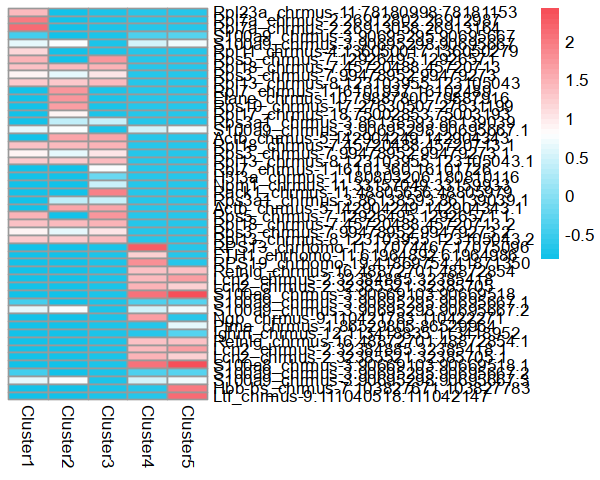

In [92]:
pheatmap(scale(gdf),
         cluster_cols = FALSE,
         cluster_rows = FALSE,
          color = colorRampPalette(c("#12c2e9","white","#f64f59"))(50)
        # scale="row"
        )->p
p_file = 'Demo/hp.Clutser_speSJ.png'
ggsave(p_file,p,width=6.5,height=8)

### dotplot of diffexpress SJs between clusters

In [95]:
de_sj_top10$`-log10(pval)` = ifelse(de_sj_top10$pval<0.00001,5,-log10(de_sj_top10$pva))
de_sj_top10$ids = factor(de_sj_top10$ids,levels = unique(c(de_sj_top10$ids)))

In [111]:
ggplot(de_sj_top10,aes(x=cluster,y=ids))+
geom_point(aes(fill=psi.g1,size = `-log10(pval)`),color = "black",shape = 21,alpha = 0.8)+
scale_fill_gradient(low='white',high='red')+
theme_bw()+
theme(
        axis.text.x=element_text(color = "black", size=12,angle=90),
        axis.text.y=element_text(color = "black", size=12),
        axis.title.x=element_text(color = "black", size = 13),
        axis.title.y=element_text(color = "black", size = 13),
        legend.title = element_text(color = "black", size=12),
        legend.text = element_text(color = "black", size=12)
    )->p
p_file = 'Demo/dotplot.Clutser_speSJ.png'
ggsave(p_file,p)

Saving 6.67 x 6.67 in image



### SJ diffexpression between groups

In [117]:
marvel_flt <- CompareValues.SJ.10x(MarvelObject=marvel_flt,
                               cell.group.g1=cell.ids.1,
                               cell.group.g2=cell.ids.2,
                               min.pct.cells.genes=10,
                               min.pct.cells.sj=10,
                               min.gene.norm=1.0,
                               seed=1,
                               n.iterations=100,
                               downsample=TRUE,
                               show.progress=FALSE
                               )
marvel_flt <- CompareValues.Genes.10x(MarvelObject=marvel_flt,
                                  show.progress=FALSE
                                  )

552 cells from Group 1 and 552 cells from Group 2 included

5704 genes expressed in cell group 1

6180 genes expressed in cell group 2

5254 genes expressed in BOTH cell group and retained

772 genes with mean log2(expression + 1) > 1 retained

3298 SJ expressed in cell group 1

3554 SJ expressed in cell group 2

3699 SJ expressed in EITHER cell groups and retained

Total of 3699 SJ from 732 genes included for DE analysis

Computing PSI for cell group 1...

Computing PSI for cell group 2...

Creating null distributions...

Computing P values...

Performing Wilcox rank sum test...



In [119]:
 write.table(marvel_flt$DE$SJ$Table,paste0('Demo/diffsj_group/','group1vsgroup2','_diffsj.xls'),sep = "\t",quote = FALSE)

Warning message:
“Removed 3699 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 3699 rows containing missing values (geom_text_repel).”


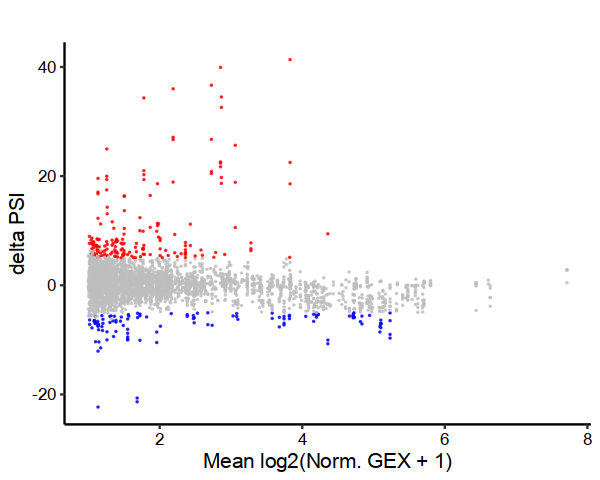

In [122]:
marvel_flt <- PlotDEValues.SJ.10x(MarvelObject=marvel_flt,
                              pval=0.05,
                              delta=5,
                              min.gene.norm=1.0,
                              anno=FALSE
                              )
marvel_flt$DE$SJ$VolcanoPlot$SJ$Plot
p_file = '/Personal/fuxin/sgr06/RD/FullLength/Demo/volcano.groupdiff_SJ.png'
ggsave(p_file,marvel_flt$DE$SJ$VolcanoPlot$SJ$Plot,width=3,height=3)

In [127]:
marvel_flt$DE$SJ$Table%>%
    mutate(ids = paste0(gene_short_name,'_',`coord.intron`))->gdf
gdf[order(gdf$delta,decreasing = TRUE),]->gdf
h_df = gdf[1:15,]
gdf[order(gdf$delta,decreasing = FALSE),]->gdf
l_df = gdf[1:15,]

In [133]:
rbind(h_df,l_df)%>%select(ids,psi.g1,psi.g2)->gdf
rownames(gdf) = gdf$ids
gdf = gdf[,-1]

Saving 5 x 6.67 in image



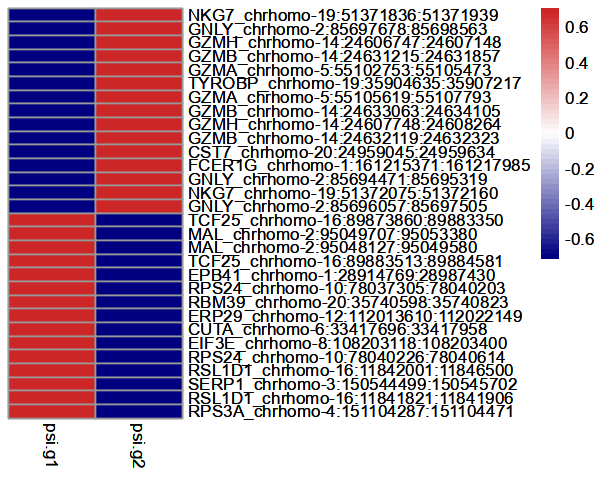

In [140]:
pheatmap(gdf,
         cluster_cols = FALSE,
         cluster_rows = FALSE,
          color = colorRampPalette(c("navy","white","firebrick3"))(50),
         scale="row"
        )->p
p
p_file = 'Demo/heatmap.groupdiff_SJ_top15.png'
ggsave(p_file,p,width=5)

### Splice dynamic analysis

In [141]:
marvel_flt <- IsoSwitch.10x(MarvelObject=marvel_flt,
                        pval.sj=0.05,
                        delta.sj=5,
                        min.gene.norm=1.0,
                        pval.adj.gene=0.05,
                        log2fc.gene=0.5
                        )

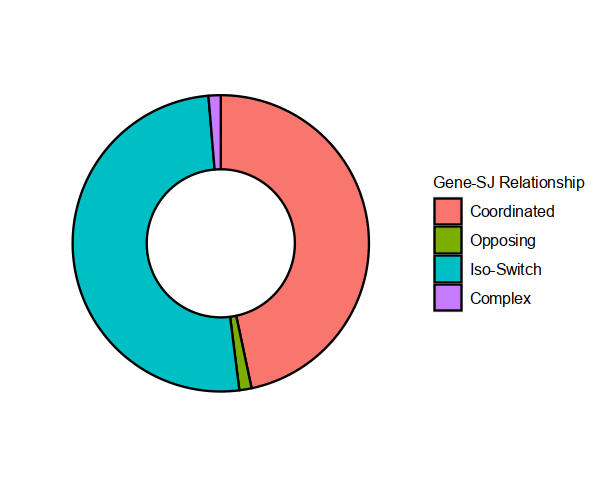

In [146]:
marvel_flt$SJ.Gene.Cor$Proportion$Plot
p_file = 'Demo/circle.gene_splice_dynamic.png'
ggsave(p_file,marvel_flt$SJ.Gene.Cor$Proportion$Plot,width=4,height=4)

### Sjs expression map to tsne

5048 cells defined with no coordinates found



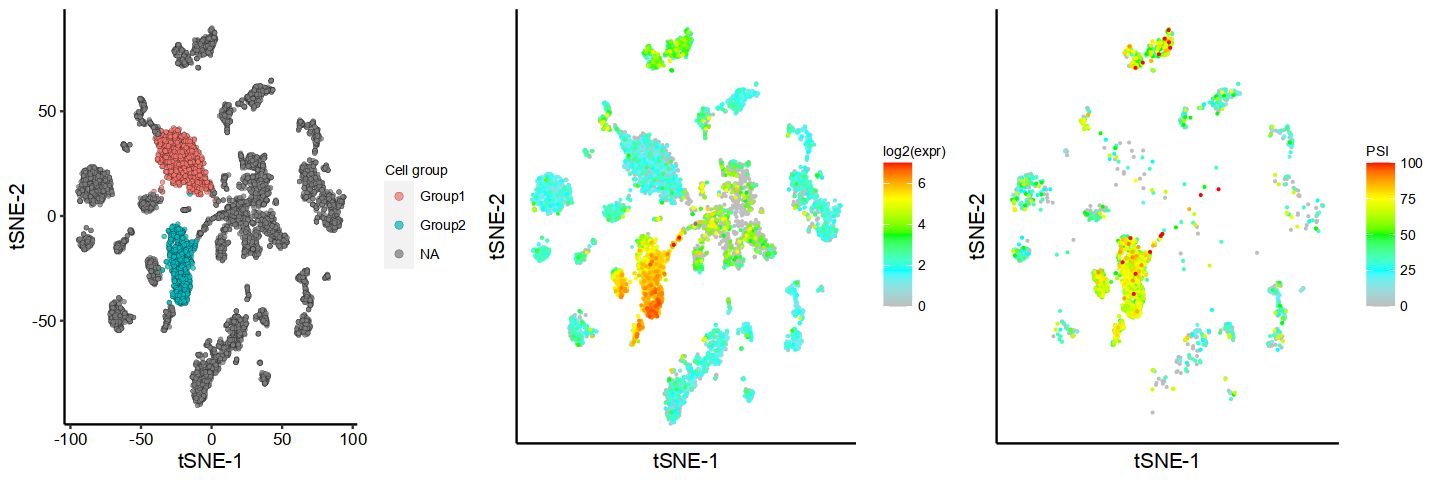

In [155]:
options(repr.plot.width=12)

cell.group.list <- list("Group1"=cell.ids.1,
                        "Group2"=cell.ids.2
                        )

marvel_flt <- PlotValues.PCA.CellGroup.10x(MarvelObject=marvel_flt,
                                       cell.group.list=cell.group.list,
                                       legendtitle="Cell group",
                                       type="tsne"
                                       )

plot_group <- marvel_flt$adhocPlot$PCA$CellGroup

marvel_flt <- PlotValues.PCA.Gene.10x(MarvelObject=marvel_flt,
                                  gene_short_name="NKG7",
                                  color.gradient=c("grey","cyan","green","yellow","red"),
                                  type="tsne"
                                  )


plot_gene <- marvel_flt$adhocPlot$PCA$Gene

# Plot PSI
marvel_flt <- PlotValues.PCA.PSI.10x(MarvelObject=marvel_flt,
                                 coord.intron="chrhomo-19:51371836:51371939",
                                 min.gene.count=3,
                                 log2.transform=FALSE,
                                 color.gradient=c("grey","cyan","green","yellow","red"),
                                 type="tsne"
                                 )
 
plot_sj <- marvel_flt$adhocPlot$PCA$PSI

# Arrange and view plots
grid.arrange(plot_group, plot_gene, plot_sj, nrow=1)

p_file = 'Demo/tsne.plot_group.png'
ggsave(p_file,plot_group,width=5,height=4.5)
p_file = 'Demo/tsne.plot_gene_NKG7.png'
ggsave(p_file,plot_gene,width=5,height=4.5)
p_file = 'Demo/tsne.plot_sj_NKG7_chrhomo_19_51371836_51371939.png'
ggsave(p_file,plot_sj,width=5,height=4.5)

### Enrich analysis

In [163]:
marvel_flt <- BioPathways.10x(MarvelObject=marvel_flt,
                          pval=0.05,
                          delta=5,
                          min.gene.norm=1.0,
                          method.adjust="fdr",
                          species="human"
                          )

133 unique genes identified for GO analysis

'select()' returned 1:1 mapping between keys and columns



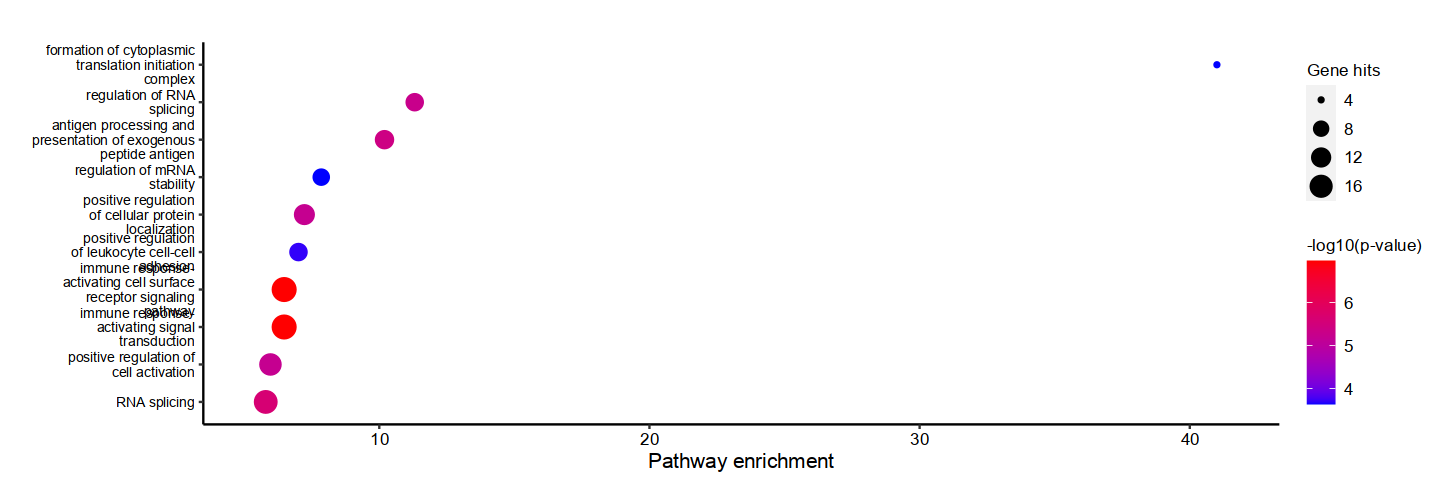

In [166]:
go.terms = marvel_flt$DE$BioPathways$Table$Description[1:10]
marvel_flt <- BioPathways.Plot.10x(MarvelObject=marvel_flt,
                               go.terms,
                               y.label.size=8,
                               offset=0.5
                               )
marvel_flt$DE$BioPathways$Plot
p_file = 'Demo/dotplot.GO_enrich.png'
ggsave(p_file,marvel_flt$DE$BioPathways$Plot,width=5,height=4.5)

### dotplot of specific SJs expression 

Downsampling to 552 cells per group



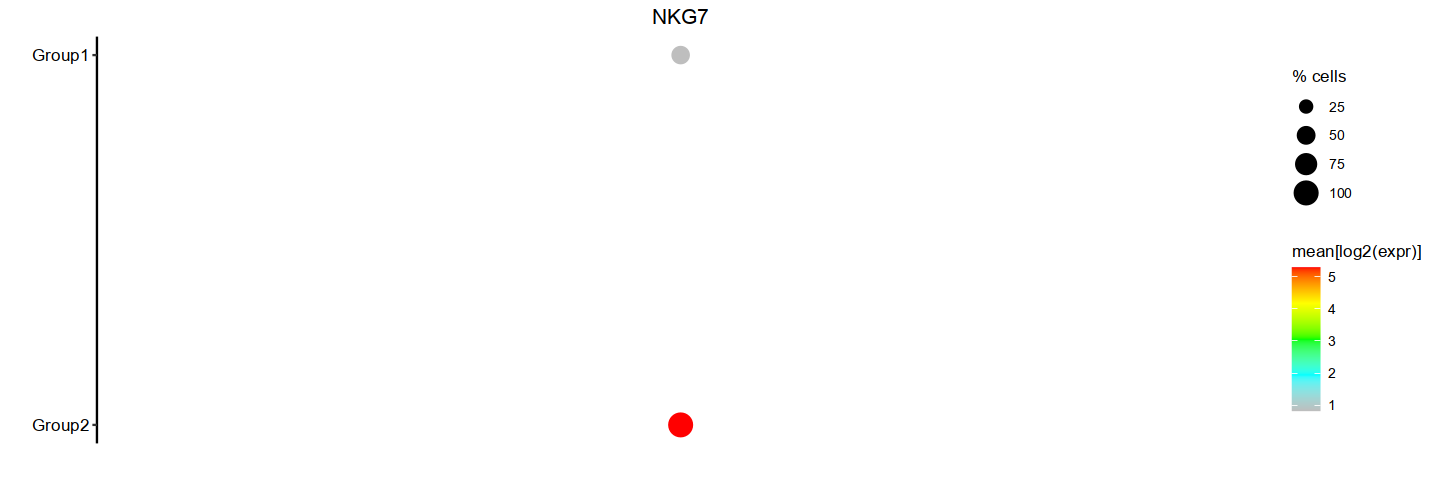

In [173]:
marvel_flt <- adhocGene.TabulateExpression.Gene.10x(MarvelObject=marvel_flt,
                                                cell.group.list=cell.group.list,
                                                gene_short_name="NKG7",
                                                min.pct.cells=10,
                                                downsample=TRUE
                                                )

marvel_flt$adhocGene$Expression$Gene$Plot

p_file = 'Demo/dotplot.gene_TabulateExpression.png'
ggsave(p_file,marvel_flt$adhocGene$Expression$Gene$Plot,width=3,height=3)

In [ ]:
marvel_flt <- adhocGene.TabulateExpression.PSI.10x(MarvelObject=marvel_flt,
                                               min.pct.cells=10)

marvel_flt$adhocGene$Expression$PSI$Plot

p_file = 'Demo/dotplot.PSI_TabulateExpression.png'
ggsave(p_file,marvel_flt$adhocGene$Expression$PSI$Plot,width=5,height=3)

In [2]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /Personal/fuxin/.conda/envs/r_4.1/lib/libopenblasp-r0.3.23.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] dplyr_1.1.4.9000      SeuratObject_4.0.2    Seurat_4.0.4         
 [4] gridExtra_2.3         data.table_1.14.0     Matrix_1.3-4         
 [7] wiggleplotr_1.26.0    GenomicRanges_1.44.0  GenomeInfoDb_1.28.4  
[10] gtools_3.9.2          org.Mm.eg.db_3.13.0   org.Hs.eg.db_3.13